# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

# Convolutional Neural Network

## Ziel: 
### Training vom ersten Model mit [Cloud Computing Power](https://neptune.ml/)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib
import numpy as np
#from scipy.misc import imresize

from __future__ import unicode_literals # bc of ü, ö, ä ...

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

## Kategorien die sich ähneln oder keinen Mehwert ergeben (z.B "griechische", "weisse", "blech",...) werden gelöscht. Es bleiben noch 230 Kategorien

In [2]:
!ls ./input/images/images/

ananas                        lachs
apfel                         lachsfilet
apfelkuchen                   lamm
aprikosen                     lammkeule
art                           lasagne
asiatische                    lauch
auberginen                    lebkuchen
auflauf                       likör
avocado                       limetten
bananen                       linsen
bananenkuchen                 linsensuppe
bandnudeln                    low_carb
basilikum                     mais
beeren                        makkaroni
birnen                        mandarinen
blechkuchen                   mandel
blumenkohl                    mango
blätterteig                   marinierte
blätterteigtaschen            marmelade
bohnen                        marmorkuchen
bohnensalat                   marzipan
bohnensuppe                   mascarpone_creme
bolognese                     maultaschen
bowle                         milchreis
bratapfel                     mohn
bratkartoffeln           

In [22]:
root_dir = './input/images/images/'
ingore_files = ['.DS_Store', 'neptune.log']

sorted_food_dirs = [fd for fd in sorted(os.listdir(root_dir)) if not fd in ingore_files]

for i in range(len(sorted_food_dirs)):
    path = os.path.join(root_dir, sorted_food_dirs[i])
    for i, filename in enumerate(os.listdir(path)):
        src = f"{path}/{filename}"
        name = filename.split('.')[0] + ".jpeg"
        dst = f"{path}/{name}"
        os.rename(src, dst)


<ipython-input-23-7b150d6daa8c>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


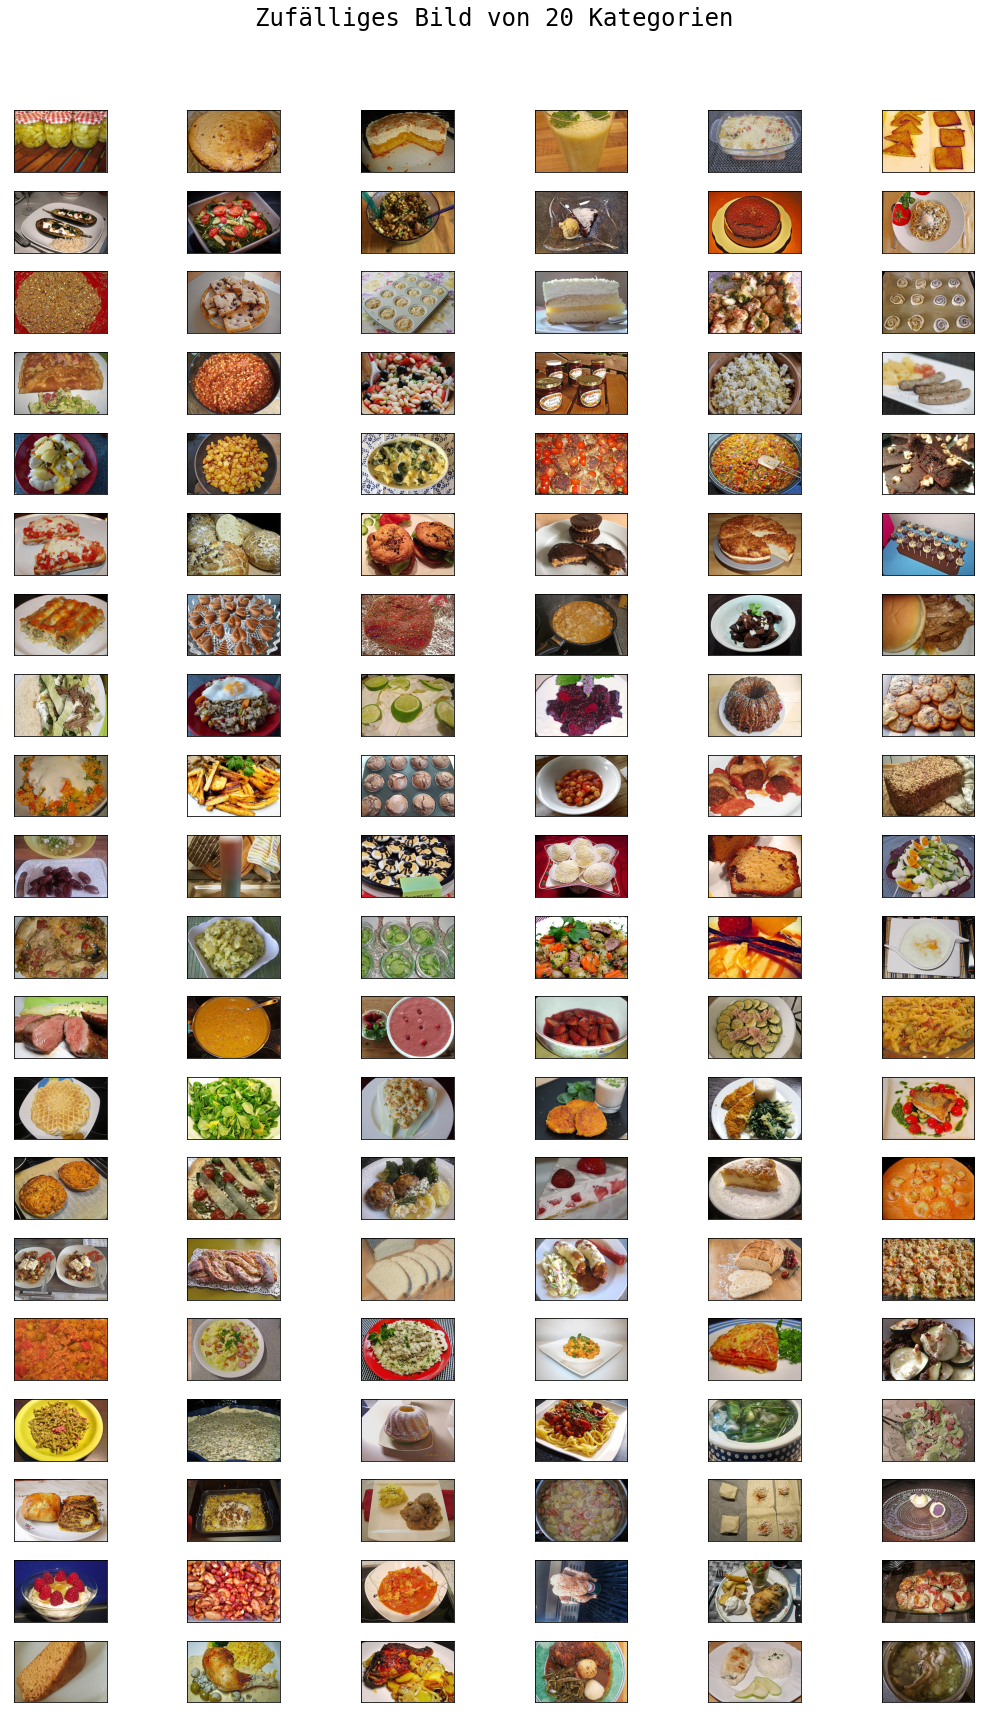

In [23]:
matplotlib.rc('font',family='monospace')
plt.style.use('seaborn-poster')

root_dir = './input/images/images/'
rows = 20
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Zufälliges Bild von 20 Kategorien', fontsize=24)
ingore_files = ['.DS_Store', 'neptune.log']
sorted_food_dirs = [fd for fd in sorted(os.listdir(root_dir)) if not fd in ingore_files]

for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (.7, 0, 0)
        fc = (0.9, 0, 0)
        ax[i][j].text(0, -18, food_dir, size=0, rotation=0,
                ha="center", va="center", color='w',)
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [24]:
import multiprocessing as mp
num_processes = 8
pool = mp.Pool(processes=num_processes)

In [25]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [26]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16585615075198836068
 xla_global_id: -1]

In [27]:
import psutil
psutil.virtual_memory()

svmem(total=68719476736, available=52906946560, percent=23.0, used=15809654784, free=33658757120, active=11615735808, inactive=17285742592, wired=4193918976)

In [29]:
import pathlib

data_dir = pathlib.Path("./input/images/images")

image_count = len(list(data_dir.glob('*/*.jpeg')))
print(image_count)


108823


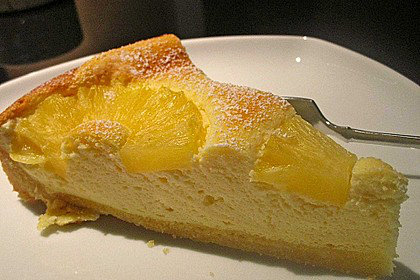

In [30]:
import PIL
ananas = list(data_dir.glob("ananas/*"))
PIL.Image.open(str(ananas[2]))

In [31]:
batch_size = 32
img_height = 224
img_width = 224
test_size = int(image_count * 0.15/32)
print(test_size)

510


In [32]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 108823 files belonging to 300 classes.
Using 76177 files for training.


In [33]:
list_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 108823 files belonging to 300 classes.
Using 32646 files for validation.


In [34]:
test_ds = list_ds.take(test_size)
val_ds = list_ds.skip(test_size)

In [35]:
# print the size of each dataset (number of batches)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

2381
511
510


In [36]:
class_names = train_ds.class_names
print(class_names)

['ananas', 'apfel', 'apfelkuchen', 'aprikosen', 'art', 'asiatische', 'auberginen', 'auflauf', 'avocado', 'bananen', 'bananenkuchen', 'bandnudeln', 'basilikum', 'beeren', 'birnen', 'blechkuchen', 'blumenkohl', 'blätterteig', 'blätterteigtaschen', 'bohnen', 'bohnensalat', 'bohnensuppe', 'bolognese', 'bowle', 'bratapfel', 'bratkartoffeln', 'brokkoli', 'brot', 'brotaufstrich', 'brownies', 'bruschetta', 'brötchen', 'burger', 'butter', 'bärlauch', 'cake', 'cannelloni', 'cappuccino', 'carpaccio', 'champignon', 'champignons', 'cheesecake', 'chicken', 'chili', 'chinakohl_eintopf', 'chutney', 'cocktail', 'cookies', 'couscous', 'cremesuppe', 'cupcakes', 'curry', 'curry_con_carne', 'dinkel_vollkornbrot', 'dip', 'dressing', 'eier', 'eierlikör', 'eierlikörkuchen', 'eiersalat', 'einfache', 'einfacher', 'eingelegte', 'eintopf', 'eis', 'ente', 'entenbrust', 'erbsensuppe', 'erdbeer', 'erdbeeren', 'error', 'feigen', 'feine', 'feldsalat', 'fenchel', 'feta', 'fisch', 'fischfilet', 'fladenbrot', 'flammkuche

In [37]:
num_of_class = len(class_names)
print(num_of_class)

300


In [38]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [39]:
#Standardize the data
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [40]:
#Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. 
#These are two important methods you should use when loading data

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [41]:
num_classes = num_of_class

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [42]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [43]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
 435/2381 [====>.........................] - ETA: 13:12 - loss: 4.2978 - accuracy: 0.3344

InvalidArgumentError: Graph execution error:

jpeg::Uncompress failed. Invalid JPEG data or crop window.
	 [[{{node decode_image/DecodeImage}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_1525]